# Handwritten Digit Recognition

## Setting up and Importing the Dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms

import math
import matplotlib.pyplot as plt

import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from skimage.transform import resize
from sklearn.model_selection import train_test_split

from pathlib import Path

from PIL import Image
import cv2

import pandas as pd

from torchvision import datasets
from torchvision.transforms import ToTensor
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
testing_letter = pd.read_csv('emnist/emnist-letters-test.csv')
training_letter = pd.read_csv('emnist/emnist-letters-train.csv')

In [3]:
# Prepare data
train_labels = np.array(training_letter.iloc[:,0].values)
train_features = np.array(training_letter.iloc[:,1:].values)
test_labels = np.array(testing_letter.iloc[:,0].values)
test_features = np.array(testing_letter.iloc[:,1:].values)

In [4]:
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

In [5]:
class CustomDataset(Dataset):
    def __init__(self, features, labels, classes=None, transform=None, threshold=0.5):
        """
        Args:
            features (numpy.ndarray or torch.Tensor): The input data.
            labels (numpy.ndarray or torch.Tensor): The target labels.
            classes (list or None): List of class names (if applicable).
            transform (callable, optional): A function/transform to apply to each image.
            threshold (float): Pixel values above this will be set to white (1.0), others to black (0.0).
        """
        self.features = features / 255.0  # Normalize to [0, 1] if not already
        self.labels = labels - 1  # Adjust labels to 0-based index
        self.classes = classes
        self.transform = transform
        self.threshold = threshold

        # For compatibility with torchvision-like datasets
        self.data = self.features
        self.targets = self.labels

        # Class mappings
        if self.classes:
            self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
            self.idx_to_class = {idx: cls for idx, cls in enumerate(self.classes)}
        else:
            self.class_to_idx = None
            self.idx_to_class = None

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.features[idx]
        label = self.labels[idx]

        # Reshape and transpose (for EMNIST compatibility)
        image = image.reshape(28, 28).T

        # Apply binary thresholding
        image = np.where(image > self.threshold, 1.0, 0.0)

        # Convert back to tensor
        image = torch.tensor(image, dtype=torch.float32)

        # Apply transform if provided (e.g., ToTensor() or others)
        if self.transform:
            image = self.transform(image)

        # Ensure correct shape (1 channel, 28x28)
        image = image.reshape(1, 28, 28)

        return image, label

In [6]:
by_merge_map = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 
    7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 
    14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 
    20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'
}

letter_to_number = {v: k for k, v in by_merge_map.items()}
classes = list(by_merge_map.keys())

In [7]:
train_data = CustomDataset(
    train_features_tensor,
    train_labels_tensor,
    classes=classes,
    threshold=0.5  # Adjust this value as needed
)

test_data = CustomDataset(
    test_features_tensor,
    test_labels_tensor,
    classes=classes,
    threshold=0.5
)

In [8]:
class_names = train_data.classes
len(class_names)

26

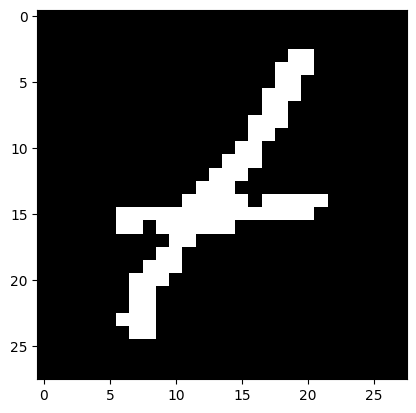

In [9]:
data, target = train_data[12333]
image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')

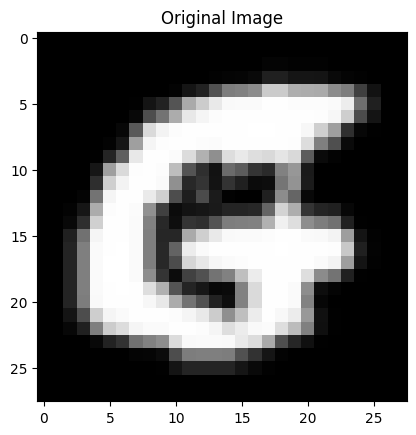

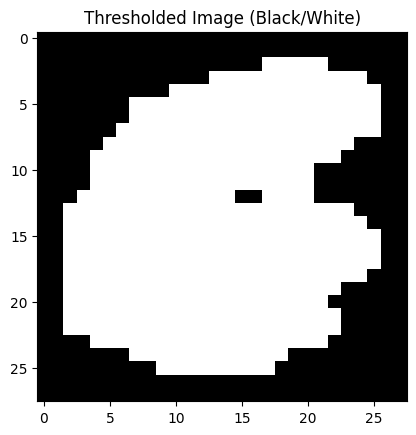

In [10]:
# Before thresholding (original)
original_image = train_features_tensor[0].reshape(28, 28).T.numpy()
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.show()

# After thresholding
thresholded_image = np.where(original_image > 0.5, 1.0, 0.0)
plt.imshow(thresholded_image, cmap='gray')
plt.title("Thresholded Image (Black/White)")
plt.show()

## Analyzing and Exploring the Data

### Training Data

In [11]:
train_data

### Testing_data

In [12]:
test_data

### Dataset Shape and Size

In [13]:
train_data.data.shape

torch.Size([88799, 784])

In [14]:
test_data.data.shape

torch.Size([14799, 784])

In [15]:
train_data.targets.shape

torch.Size([88799])

In [16]:
train_data.targets

tensor([ 6, 15, 14,  ...,  0, 22, 11])

## Creating Data Loader

In [17]:
loaders = {
    'train': DataLoader(train_data, batch_size=100, shuffle=True, num_workers=0),
    'test': DataLoader(test_data, batch_size=100, shuffle=True, num_workers=0)
}

In [18]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x146a19a60>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x146b1ee70>}

## Creating the Machine Learning Model

In [19]:
DROPOUT = 0.6

In [20]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Feature extraction layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5)  # Input: 1 channel (grayscale)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv2_drop = nn.Dropout2d(p=DROPOUT)

        # Calculate flattened size correctly:
        # Input: 28x28
        # After conv1 (kernel=5, no padding): 28-5+1 = 24x24
        # After maxpool (kernel=2): 12x12
        # After conv2 (kernel=5): 12-5+1 = 8x8
        # After maxpool (kernel=2): 4x4
        self.flattened_size = 32 * 4 * 4  # 32 channels * 4x4 spatial dim

        # Classification head
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc1_drop = nn.Dropout(p=DROPOUT)
        self.fc2 = nn.Linear(128, 26)  # 26 classes for A-Z

    def forward(self, x):
        # Input shape: [batch, 1, 28, 28]

        # Conv1 -> BN -> ReLU -> MaxPool
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), kernel_size=2))  # [B, 16, 12, 12]

        # Conv2 -> BN -> Dropout -> ReLU -> MaxPool
        x = F.relu(F.max_pool2d(self.conv2_drop(self.bn2(self.conv2(x))), kernel_size=2))  # [B, 32, 4, 4]

        # Flatten
        x = x.view(-1, self.flattened_size)

        # FC layers
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

## Optimizing the Machine Learning Model using CUDA

In [21]:
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

## Creating the Dataset Training Mode

In [22]:
train_losses = []
train_accuracies = []

In [23]:
def train(epoch):
    model.train()  # Set model to training mode (enables dropout)
    running_loss = 0.0
    correct = 0  # To count correct predictions
    total = 0    # To count total samples

    for batch_idx, (data, target) in enumerate(loaders['train']):
        optimizer.zero_grad()  # Clear gradients
        output = model(data)  # Forward pass
        loss = loss_fn(output, target)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()

        # Calculate accuracy
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()  # Count correct predictions
        total += target.size(0)  # Count total samples

        # Print training progress
        if batch_idx % 20 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)} / {len(loaders['train'].dataset)} "
                  f"({100. * batch_idx / len(loaders['train']):.0f}%)]\tLoss: {loss.item():.6f}")

    # Calculate average loss and accuracy for the epoch
    avg_train_loss = running_loss / len(loaders['train'])
    train_accuracy = 100. * correct / total

    # Store training loss and accuracy
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"\nTrain Epoch: {epoch}\tAverage Loss: {avg_train_loss:.6f}\tAccuracy: {train_accuracy:.2f}%\n")

## Creating the Dataset Testing Mode

In [24]:
test_losses = []
test_accuracies = []

In [25]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loaders['test']:
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    # Calculate average test loss and accuracy
    test_loss /= len(loaders['test'])
    accuracy = 100. * correct / len(loaders['test'].dataset)
    
    # Store test loss and accuracy
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders['test'].dataset)} ({accuracy:.2f}%)\n")

## Starting the Dataset Training Process

In [26]:
for epoch in range(1, 11):
    train(epoch)
    test()

Train Epoch: 1 [0 / 88799 (0%)]	Loss: 3.535102
Train Epoch: 1 [2000 / 88799 (2%)]	Loss: 3.150237
Train Epoch: 1 [4000 / 88799 (5%)]	Loss: 2.866844
Train Epoch: 1 [6000 / 88799 (7%)]	Loss: 2.498639
Train Epoch: 1 [8000 / 88799 (9%)]	Loss: 2.359387
Train Epoch: 1 [10000 / 88799 (11%)]	Loss: 1.992440
Train Epoch: 1 [12000 / 88799 (14%)]	Loss: 1.945373
Train Epoch: 1 [14000 / 88799 (16%)]	Loss: 1.726840
Train Epoch: 1 [16000 / 88799 (18%)]	Loss: 1.872839
Train Epoch: 1 [18000 / 88799 (20%)]	Loss: 1.540688
Train Epoch: 1 [20000 / 88799 (23%)]	Loss: 1.543070
Train Epoch: 1 [22000 / 88799 (25%)]	Loss: 1.681385
Train Epoch: 1 [24000 / 88799 (27%)]	Loss: 1.471122
Train Epoch: 1 [26000 / 88799 (29%)]	Loss: 1.607306
Train Epoch: 1 [28000 / 88799 (32%)]	Loss: 1.457383
Train Epoch: 1 [30000 / 88799 (34%)]	Loss: 1.509480
Train Epoch: 1 [32000 / 88799 (36%)]	Loss: 1.289171
Train Epoch: 1 [34000 / 88799 (38%)]	Loss: 1.156123
Train Epoch: 1 [36000 / 88799 (41%)]	Loss: 1.205234
Train Epoch: 1 [38000 / 8

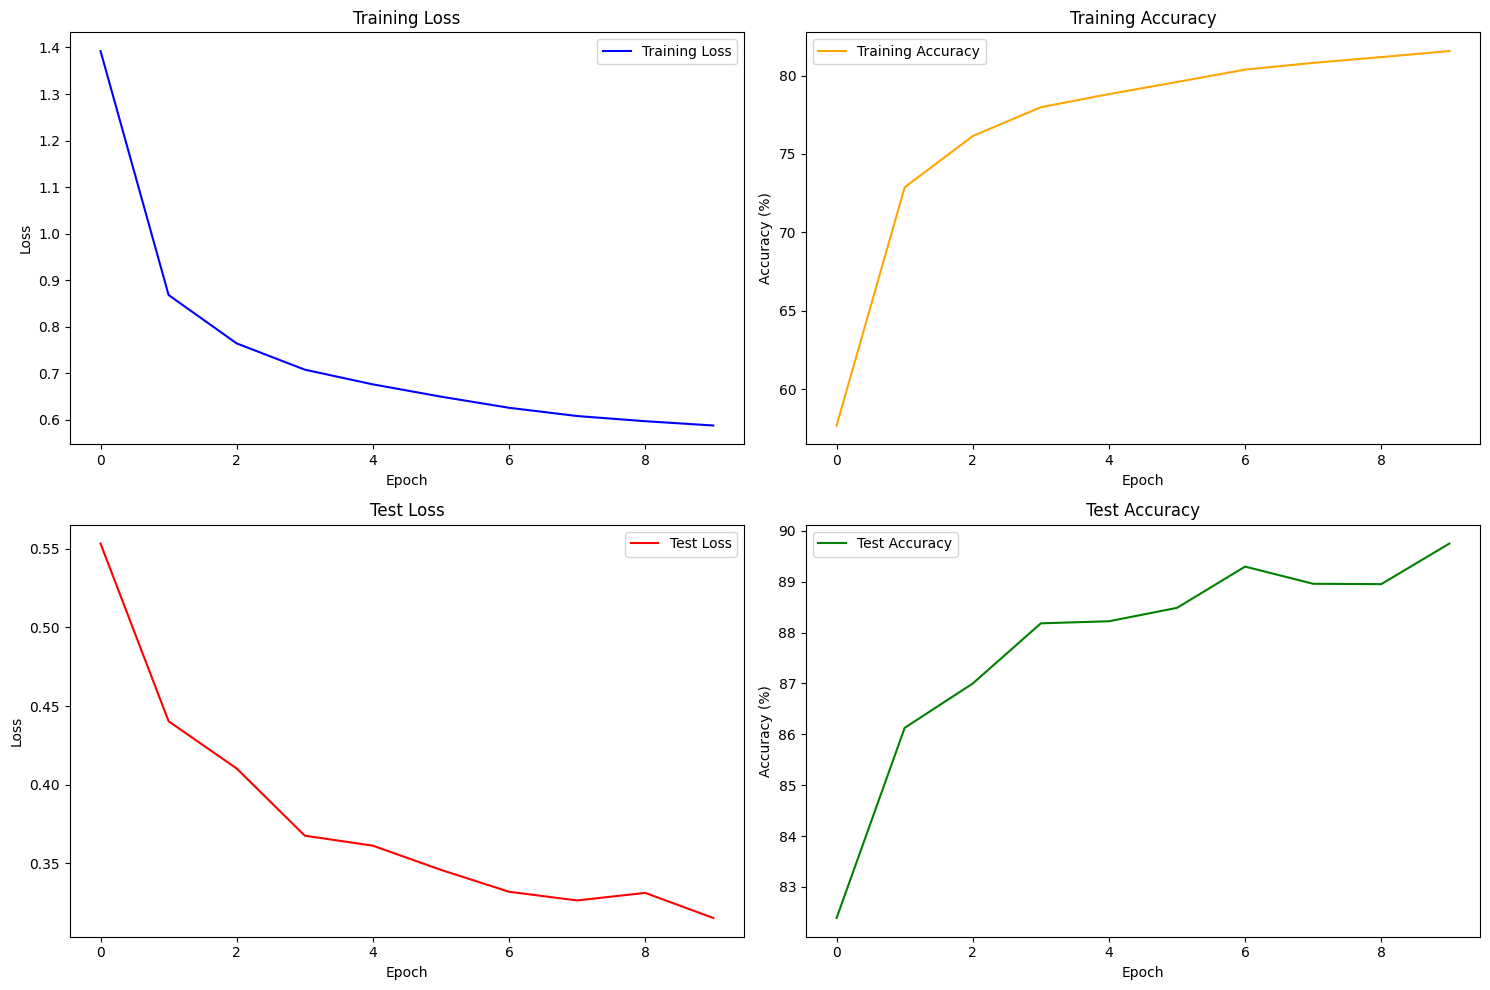

In [27]:
plt.figure(figsize=(15, 10))

# Plot Training Loss (Top Left)
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot Training Accuracy (Top Right)
plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.legend()

# Plot Test Loss (Bottom Left)
plt.subplot(2, 2, 3)
plt.plot(test_losses, label='Test Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

# Plot Test Accuracy (Bottom Right)
plt.subplot(2, 2, 4)
plt.plot(test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Visualizing the Machine Learning Model

In [28]:
def predict_and_visualize(test_data, model, index, by_merge_map):
    # Set the model to evaluation mode
    model.eval()
    
    # Get the data and target from the test dataset
    data, target = test_data[index]

    
    # Prepare the data for the model
    data = data.unsqueeze(0)
    
    # Get the model's prediction
    output = model(data)
    prediction = output.argmax(dim=1, keepdim=True).item()
    
    # Get the predicted label and the real label
    predicted_label = by_merge_map.get(prediction)
    real_label = by_merge_map.get(target.item())
    
    # Print the prediction and real label
    print(f"Prediction: {predicted_label}")
    print(f"Real Label: {real_label}")
    
    # Prepare the image for visualization
    image = data.squeeze(0).squeeze(0).cpu().numpy()
    
    # Display the image
    plt.imshow(image, cmap='gray')
    plt.title(f"Prediction: {predicted_label}\nReal Label: {real_label}")
    plt.axis('off')
    plt.show()

Prediction: G
Real Label: Q


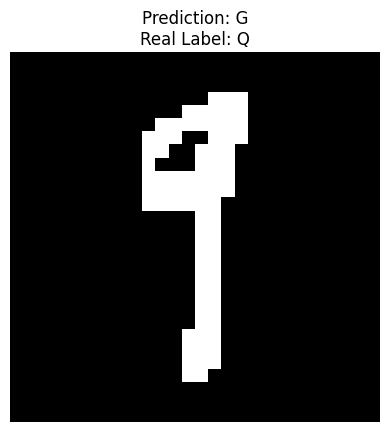

In [29]:
predict_and_visualize(test_data, model, 13232, by_merge_map)

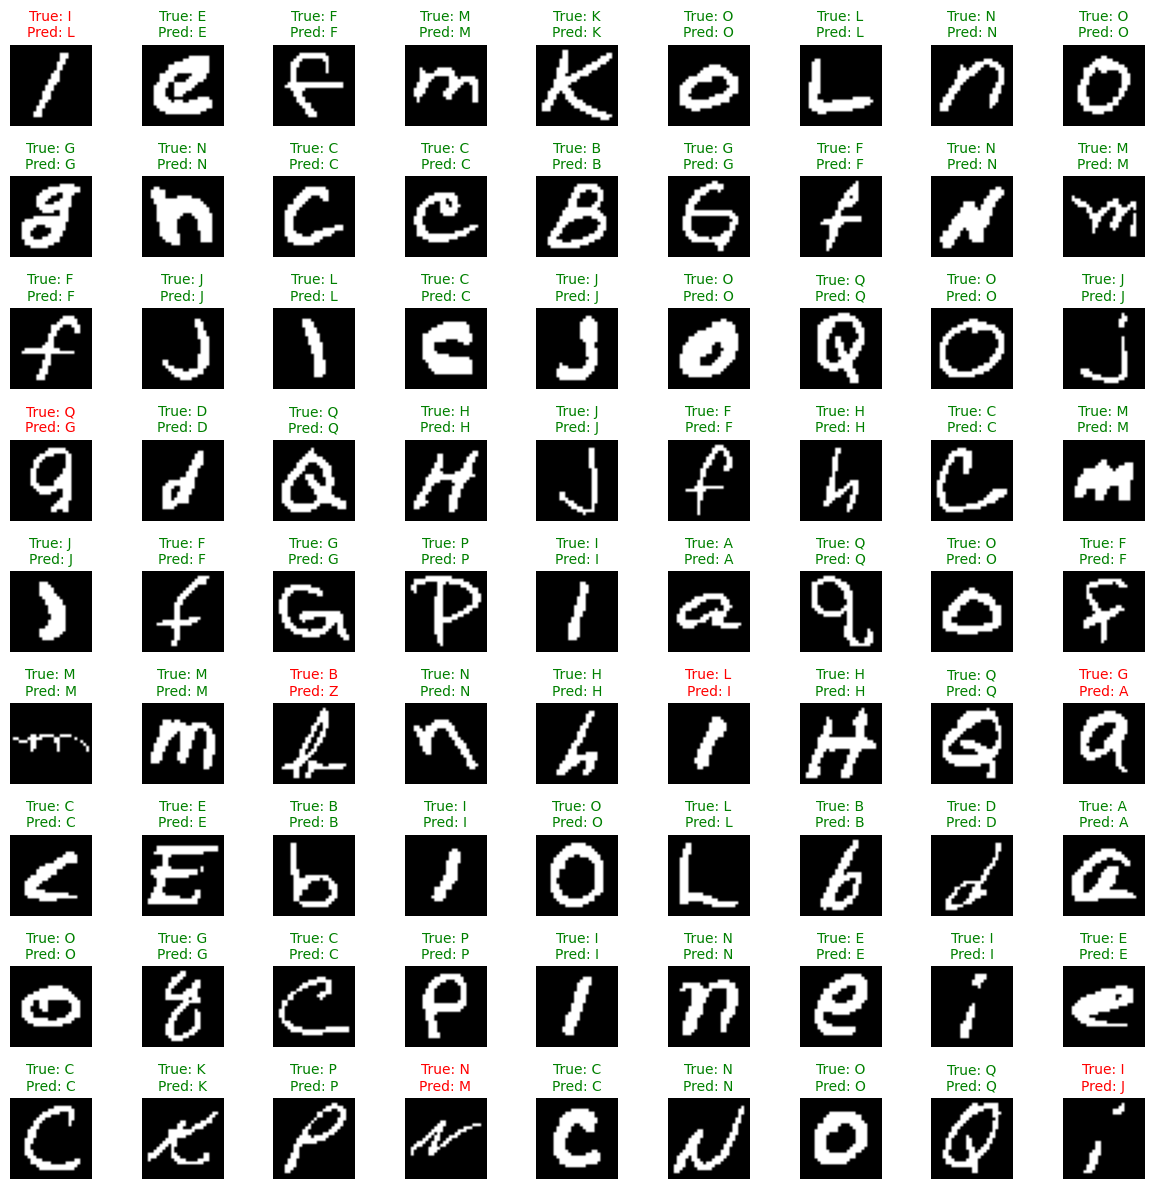

In [30]:
def plot_image_grid(model, data_loader, num_images=81):
    model.eval()  # Set the model to evaluation mode
    fig, axes = plt.subplots(9, 9, figsize=(12, 12))  # Create a 9x9 grid
    axes = axes.ravel()  # Flatten the axes to easily iterate

    # Get a batch of data
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    images, labels = images, labels

    # Perform predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    for i in range(min(num_images, len(images))):
        ax = axes[i]
        ax.imshow(images[i].cpu().squeeze(0), cmap='gray')  # Show image

        title_text = f"True: {by_merge_map[labels[i].item()]}\nPred: {by_merge_map[preds[i].item()]}"
        
        if by_merge_map[labels[i].item()] == by_merge_map[preds[i].item()]:
            ax.set_title(title_text, fontsize=10, c="g") # green text if prediction same as truth
        else:
            ax.set_title(title_text, fontsize=10, c="r")
            
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Plot a 9x9 grid of images with true and predicted labels
plot_image_grid(model, loaders['test'])

## Prediction on the new data

In [31]:
# Load the image
image = Image.open("app_ui/canvas_output.png").convert('L')  # Convert to grayscale

# Resize the image to 28x28 pixels
image = image.resize((28, 28))

# Convert the image to a numpy array and normalize pixel values
image_array = np.array(image) / 255.0  # Normalize to [0, 1]
# Convert to a PyTorch tensor and add batch and channel dimensions
image_tensor = torch.tensor(image_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
image_tensor.shape

torch.Size([1, 1, 28, 28])

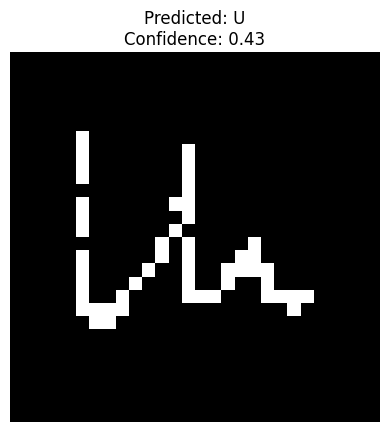

Predicted Letter: U, Confidence: 0.43


In [32]:
def predict_letter(image_path, model, by_merge_map):
    """
    Predicts the letter in the given image using the trained model and visualizes the image with the prediction.

    Args:
        image_path (str): Path to the input PNG image.
        model (torch.nn.Module): Trained PyTorch model.
        by_merge_map (dict): Dictionary mapping class indices to letters.

    Returns:
        str: Predicted letter.
        float: Confidence (probability) of the prediction.
    """
    # Load the image
    image = Image.open(image_path).convert('L')  # Convert to grayscale

    # Resize the image to 28x28 pixels
    image = image.resize((28, 28))

    # Convert the image to a numpy array and normalize pixel values
    image_array = np.array(image) / 255.0  # Normalize to [0, 1]
    # Convert to a PyTorch tensor and add batch and channel dimensions
    image_tensor = torch.tensor(image_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

    # Set model to evaluation mode
    model.eval()

    # Make prediction
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.softmax(output, dim=1)  # Apply softmax to get probabilities
        confidence, prediction = torch.max(probabilities, dim=1)  # Get confidence and predicted class index
        confidence = confidence.item()  # Convert to Python float
        prediction = prediction.item()  # Convert to Python int

    # Map the prediction to a letter
    predicted_letter = by_merge_map.get(prediction, "Unknown")

    # Visualize the image with the prediction and confidence
    plt.imshow(image_array, cmap='gray')
    plt.title(f"Predicted: {predicted_letter}\nConfidence: {confidence:.2f}")
    plt.axis('off')  # Hide axes
    plt.show()

    return predicted_letter, confidence

# Example usage:
image_path = "app_ui/canvas_output.png"
predicted_letter, confidence = predict_letter(image_path, model, by_merge_map)
print(f"Predicted Letter: {predicted_letter}, Confidence: {confidence:.2f}")

## Confusion Matrix

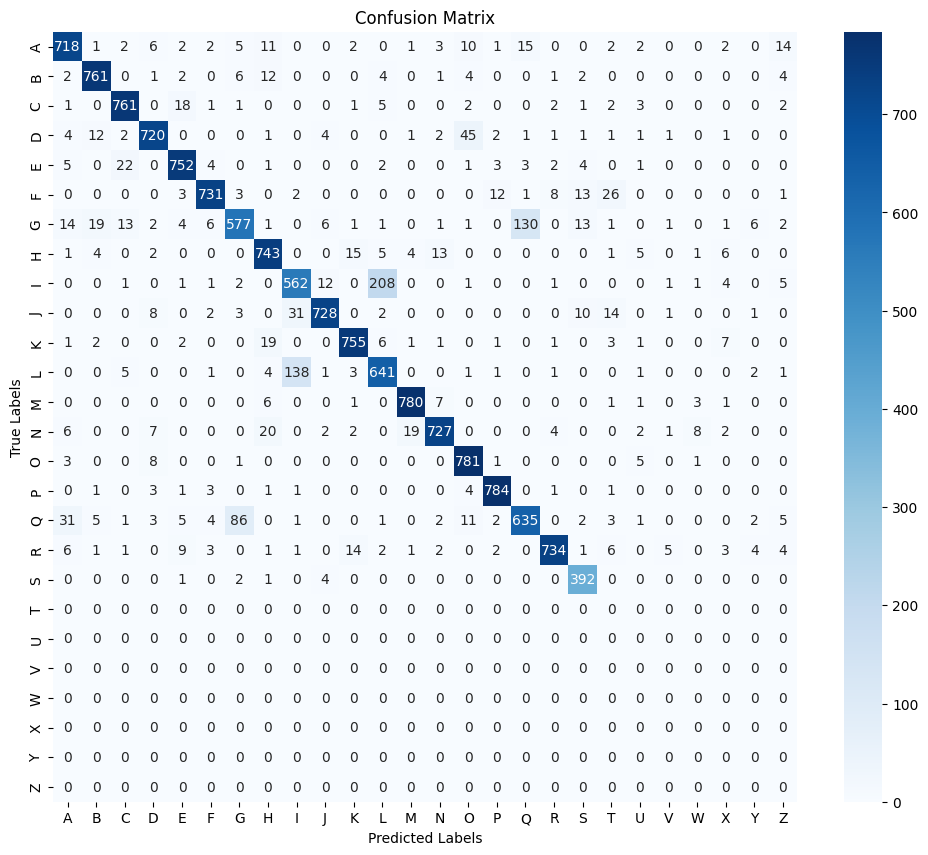

In [33]:
model.eval()  # Set the model to evaluation mode
all_preds = []
all_targets = []

with torch.no_grad():
    for data, target in loaders['test']:
        output = model(data)
        preds = output.argmax(dim=1)  # Get the predicted class indices
        # Map predicted indices to letters using by_merge_map
        preds = [by_merge_map[pred.item()] for pred in preds]
        # Map true labels to letters using by_merge_map
        targets = [by_merge_map[target.item()] for target in target]
        all_preds.extend(preds)
        all_targets.extend(targets)

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Compute the confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(by_merge_map.values()), 
            yticklabels=list(by_merge_map.values()))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Data Exporting

In [34]:
model_path = 'models/emnist_cnn_model_nogray.pth'

In [35]:
# Save the model's state dictionary
torch.save(model.state_dict(), model_path)

In [36]:
# Recreate the model architecture
loaded_model = CNN()

# Load the saved state dictionary
loaded_model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
loaded_model.eval()

/var/folders/kt/1z0_7z79269b6p7bdrjn3m340000gn/T/ipykernel_5484/2585001405.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.6, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc1_drop): Dropout(p=0.6, inplace=False)
  (fc2): Linear(in_features=128, out_features=26, bias=True)
)

Predicted: tensor([ 8, 15, 17,  7,  0, 12, 17, 13,  2, 10])
Actual: tensor([ 9, 15, 17,  7,  0, 12, 17, 13,  2, 10])


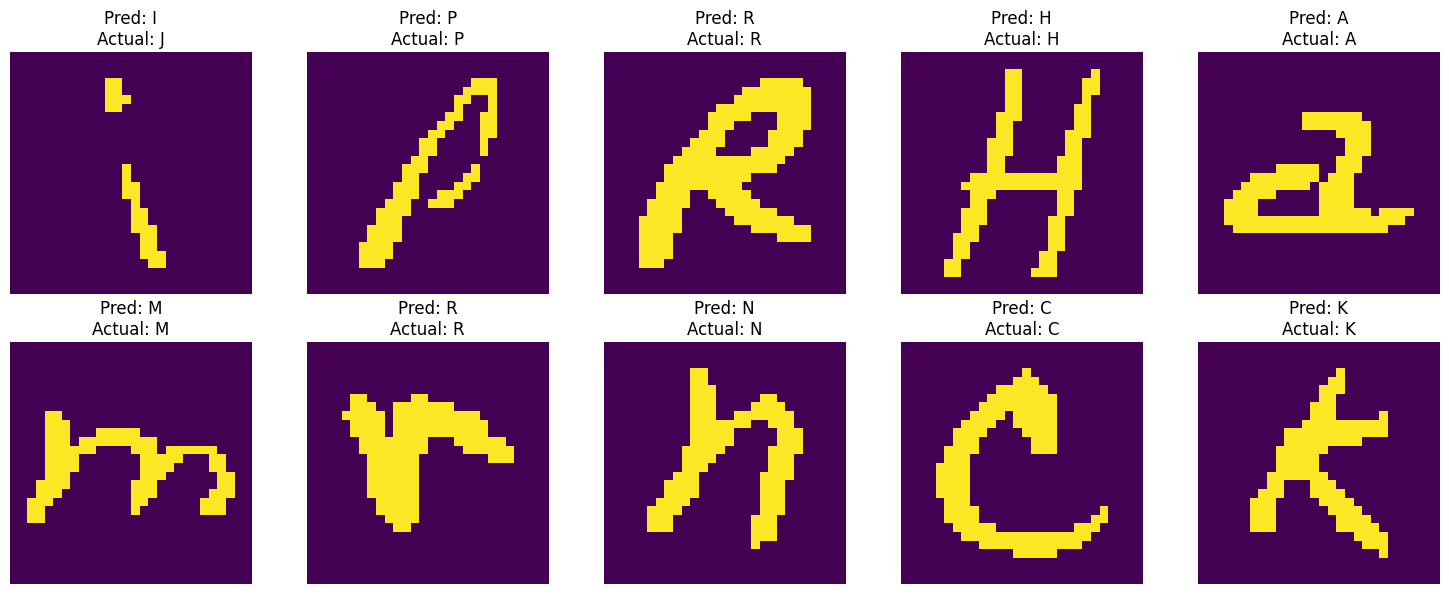

In [37]:
# Example: Predict using the loaded model
with torch.no_grad():
    test_data, test_target = next(iter(loaders['test']))
    test_data, test_target = test_data, test_target
    test_data = test_data
    output = loaded_model(test_data)
    predicted = output.argmax(dim=1)

    # Print the first few predictions
    print("Predicted:", predicted[:10])
    print("Actual:", test_target[:10])

    # Visualize the first few images along with their predicted and actual labels
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    for i, ax in enumerate(axes.flat):
        # Convert image tensor to (H, W, C) format for visualization
        ax.imshow(test_data[i].cpu().permute(1, 2, 0))
        
        # Get the predicted and actual labels using by_merge_map
        pred_label = by_merge_map.get(predicted[i].item(), "Unknown")
        actual_label = by_merge_map.get(test_target[i].item(), "Unknown")
        
        # Set the title with predicted and actual labels
        ax.set_title(f"Pred: {pred_label}\nActual: {actual_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [38]:
import os

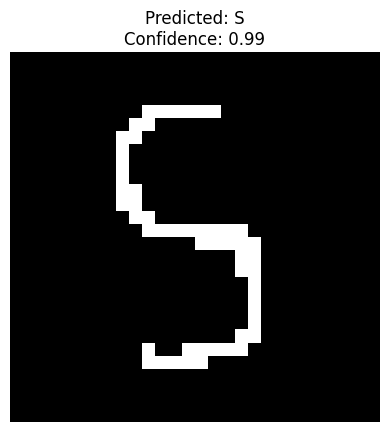

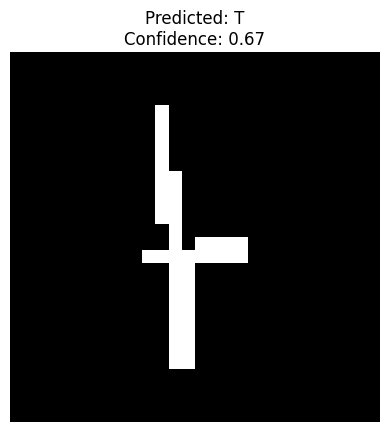

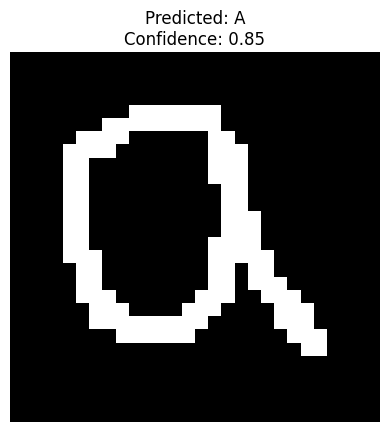

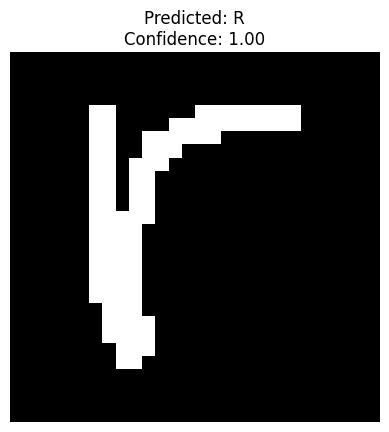

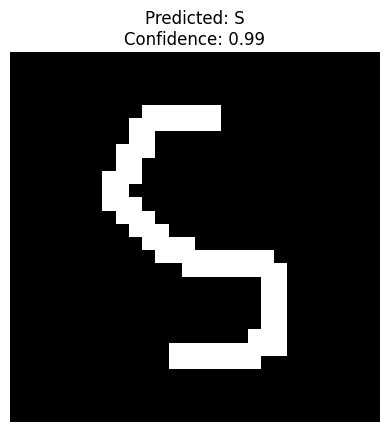

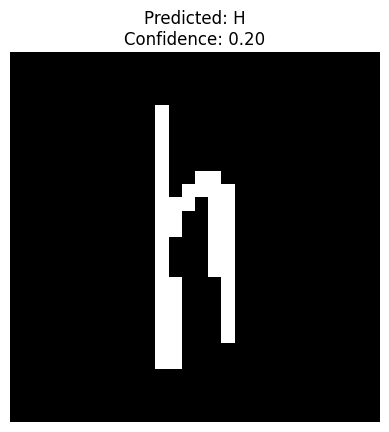

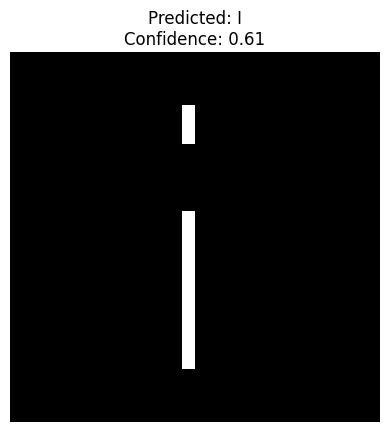

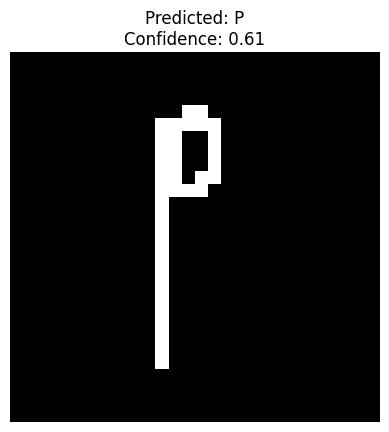

Combined predictions: STARSHIP

Individual predictions:
image_0.png: S (confidence: 0.99)
image_1.png: T (confidence: 0.67)
image_2.png: A (confidence: 0.85)
image_3.png: R (confidence: 1.00)
image_4.png: S (confidence: 0.99)
image_5.png: H (confidence: 0.20)
image_6.png: I (confidence: 0.61)
image_7.png: P (confidence: 0.61)


In [39]:
def predict_letters_from_directory(directory_path, model, by_merge_map):
    """
    Predicts letters for all PNG images in the given directory and combines them into a string.

    Args:
        directory_path (str): Path to the directory containing PNG images.
        model (torch.nn.Module): Trained PyTorch model.
        by_merge_map (dict): Dictionary mapping class indices to letters.

    Returns:
        str: Combined string of predicted letters from all images.
        list: List of tuples containing (image_path, predicted_letter, confidence) for each image.
    """
    # Get all PNG files in the directory
    image_files = [f for f in os.listdir(directory_path) if f.lower().endswith('.png')]
    image_files.sort()  # Sort to maintain order
    
    predicted_string = ""
    predictions = []
    
    for image_file in image_files:
        image_path = os.path.join(directory_path, image_file)
        
        # Load and process the image
        image = Image.open(image_path).convert('L')  # Convert to grayscale
        image = image.resize((28, 28))
        image_array = np.array(image) / 255.0
        image_tensor = torch.tensor(image_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        # Make prediction
        model.eval()
        with torch.no_grad():
            output = model(image_tensor)
            probabilities = torch.softmax(output, dim=1)
            confidence, prediction = torch.max(probabilities, dim=1)
            confidence = confidence.item()
            prediction = prediction.item()
        
        # Map the prediction to a letter
        predicted_letter = by_merge_map.get(prediction, "?")
        predicted_string += predicted_letter
        
        # Store individual prediction info
        predictions.append((image_path, predicted_letter, confidence))
        
        # Visualize the prediction (optional)
        plt.figure()
        plt.imshow(image_array, cmap='gray')
        plt.title(f"Predicted: {predicted_letter}\nConfidence: {confidence:.2f}")
        plt.axis('off')
        plt.show()
    
    return predicted_string, predictions

# Example usage:
directory_path = "new_img/"  # Directory containing your PNG images
predicted_string, individual_predictions = predict_letters_from_directory(directory_path, model, by_merge_map)

print(f"Combined predictions: {predicted_string}")
print("\nIndividual predictions:")
for img_path, letter, conf in individual_predictions:
    print(f"{os.path.basename(img_path)}: {letter} (confidence: {conf:.2f})")